# Car Price Predictor - Model Fit
### Siraj Ali

**Dataset Location**: https://www.kaggle.com/CooperUnion/cardataset

In [128]:
from joblib import dump, load
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.stattools import durbin_watson

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.tsa.api as smt

In [3]:
df = pd.read_parquet('../data_xform.parquet')

In [4]:
SEED = 11132020
FEATURES = df.columns.tolist()
TARGET = 'MSRP'

FEATURES.remove(TARGET)

## Split the data

Recalling from the EDA notebook, that most older cars were _significantly_ lower priced than newer cars. In order to better balance the data, we can stratified sample to ensure that the training and testing sets have equal distributions of newer and older cars.

In [5]:
"""
X = df[FEATURES]
y = df[TARGET]

# split train and test to 60% and 40%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=SEED)

# further split test to ultimately have 20% test and 20% validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=SEED)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
"""

# stratified split based on age - 70/30 split for train and test
stratsplit = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

for train_idx, test_idx in stratsplit.split(df, df["Age"]):
    df_train = df.iloc[train_idx]
    df_test = df.iloc[test_idx]
    
print(df_train.shape)
print(df_test.shape)

(7821, 102)
(3353, 102)


<AxesSubplot:>

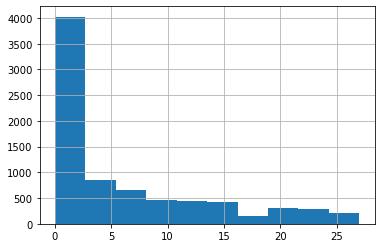

In [6]:
df_train['Age'].hist()

<AxesSubplot:>

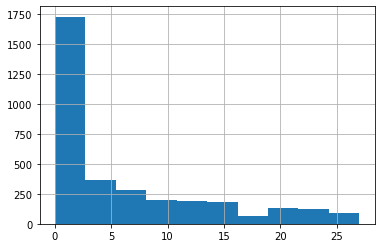

In [7]:
df_test['Age'].hist()

Separate the features and target for the train and test datasets. Also, take the log transform of the target.

In [8]:
X_train = df_train[FEATURES].values
y_train = df_train[TARGET].values

y_train_log = np.log1p(y_train)

In [9]:
X_test = df_test[FEATURES].values
y_test = df_test[TARGET].values

y_test_log = np.log1p(y_test)

## Standardize the data

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Generalized Linear Regression

Assuming that there are linear relationships between the variables and the car price, then this method provides for a quick, yet effective way to create an interpretable price-prediction model.

In [11]:
glm = LinearRegression(fit_intercept=True, normalize=False)
glm.fit(X_train, y_train_log)

LinearRegression()

In [12]:
print('Coefficients: \n', glm.coef_)

Coefficients: 
 [ 7.46467083e-02  1.16521888e-01  1.09730639e-01 -3.39329738e-02
 -2.28363629e-01 -4.80066263e+11  9.65920098e-02 -2.45757587e-02
  2.13726564e-02  4.33442748e+10  5.47790527e-02  1.59019470e-01
 -5.03540039e-04  5.00488281e-03  1.08371735e-01  2.30407715e-03
 -7.18399048e-01 -6.79552833e+10 -1.10660354e+10 -3.94508055e+10
  8.31536323e+10  1.27916790e+11 -2.99605346e+10 -6.21694699e+10
  1.55555223e+09 -2.04475580e+10 -2.51243164e+10  1.77333320e+10
 -1.80905658e+10  3.17769785e+10  3.53713639e+11 -7.08086684e+10
 -8.31055528e+09 -1.97099141e+10  3.86184053e+10 -7.98446332e+09
 -7.69003742e+10  5.80604161e+09 -1.02226561e+10 -5.17763681e+10
 -4.87544157e+10 -5.77505188e+10 -1.68026055e+10 -3.03422172e+10
 -2.05555120e+10 -6.19800711e+10 -8.80881258e+09 -5.49787553e+10
 -5.20149789e+10  2.93363821e+10 -5.55611377e+10 -2.62080258e+10
 -5.80453208e+10  4.39852150e+09 -2.45326648e+10 -3.73942558e+10
 -3.72185135e+10 -8.41065341e+09 -4.45681165e+10 -6.42645789e+10
  3.47013

## Check the R<sup>2</sup> score for train and test sets

In [13]:
r2_train = r2_score(y_train_log, glm.predict(X_train))
print(r2_train)

0.8537437732097384


In [14]:
r2_test = r2_score(y_test_log, glm.predict(X_test))
print(r2_test)

0.8476108347630871


## Check for assumptions of linear regression

Calculate model residuals from predictions and actuals, and also convert predictions and actuals back to actual prices since they were log-transformed.

In [15]:
def calculate_residuals(model, x, y):
    predictions = model.predict(x)
    df_results = pd.DataFrame({'act_log': y, 'pred_log': predictions})
    df_results['residual'] = abs(y) - abs(predictions)
    df_results['act'] = np.expm1(y)
    df_results['pred'] = np.expm1(predictions)
    return df_results

residual_df = calculate_residuals(glm, X_test, y_test_log)

In [18]:
residual_df.sample(10)

,act_log,pred_log,residual,act,pred
241,10.586104,10.345838,0.240266,39580.0,31126.232931
2309,10.005638,9.504790,0.500848,22150.0,13422.871992
1443,10.370393,10.231693,0.138699,31900.0,27768.496544
1793,9.920640,10.116799,-0.196160,20345.0,24754.406281
2261,9.903288,9.619007,0.284280,19995.0,15047.104169
8,10.561681,10.474108,0.087573,38625.0,35386.274869
2982,11.053996,11.105112,-0.051116,63195.0,66509.286640
3144,11.834291,11.808548,0.025743,137900.0,134395.297249
2790,10.432674,10.079731,0.352942,33950.0,23853.571864
3258,11.263194,11.419458,-0.156264,77900.0,91075.784414


### Multicollinearity

I already created a correlation matrix of the main effects in the `EDA.ipynb` notebook. Let's use Variance Inflation Factor (VIF) to check for multicollinearity of our (already-standardized) predictors:

Only 17 of the 101 features present have a VIF of less than infinity. Recall that a VIF of infinity means that there is perfect correlation. And generally, if VIF > 5 to 10, then moderate collinearity exists. In a real-world scenario of using linear regression, we could handle this in several ways before refitting the model:
* Remove highly correlated features
* Linearly combine some of the features
* Use Principal Component Analysis (PCA) for feature reduction

In [83]:
vif_df = pd.DataFrame()
vif_df['vars'] = FEATURES
vif_df['VIF'] = [VIF(X_train, i) for i in range(X_train.shape[1])]

In [84]:
vif_df[vif_df['VIF'] < np.inf]

,vars,VIF
0,Engine HP,11.960063
1,Engine Cylinders,6.646765
2,Number of Doors,18.652828
3,highway MPG,5.177894
4,city mpg,16.447954
6,Hybrid,1.913209
7,Crossover,3.355064
8,High-Performance,4.760641
10,Flex Fuel,5.655614
11,Exotic,11.336888


### Linearity

Let's validate the assumption that there exists a linear relationship between the predictors and the target variable of car price.

There appears to be somewhat of a linear relationship that is captured alright, but we can see that it is not perfect. Looking at the residuals, there seems to be two groupings, and the second grouping has a slight curvature deviating from a perfectly linear `y = x` line. This suggests that using another algorithm to accommadate non-linear data may work better.

In [19]:
def residual_plot(df, x, y, title):
    sns.lmplot(x=x, y=y, data=df, fit_reg=False, height=7)
    line = np.arange(df[y].min(), df[y].max())
    plt.plot(line, line, color='orange', linestyle='--')
    plt.title(title)
    plt.show()

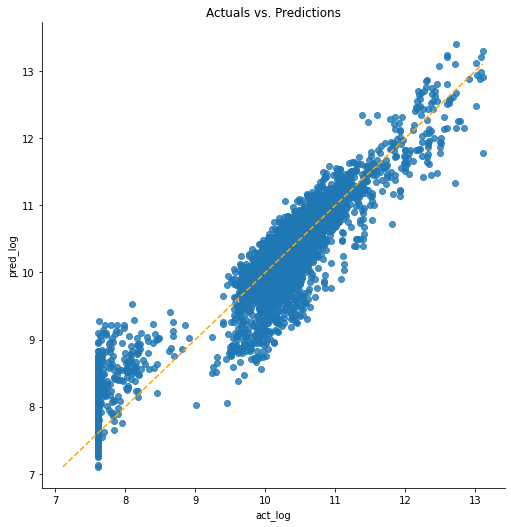

In [21]:
residual_plot(residual_df, 'act_log', 'pred_log', 'Actuals vs. Predictions')

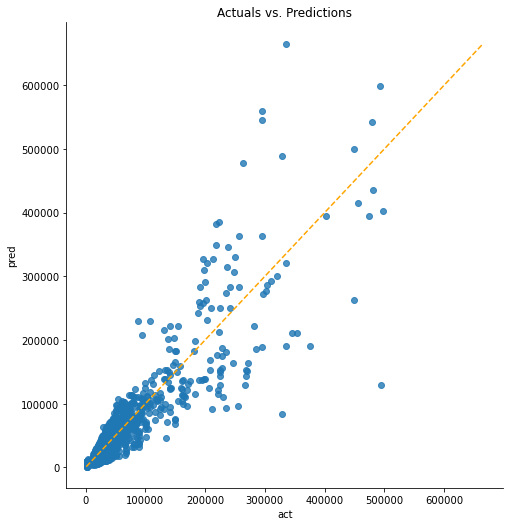

In [85]:
residual_plot(residual_df, 'act', 'pred', 'Actuals vs. Predictions')

### Normality of errors

The residuals of the model should be normally distributed. If they are not, then this assumption is violated. Looking at the residuals, we can see that they are _mostly_ normally distributed:

C:\Users\siraj\miniconda3\envs\kaggle\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


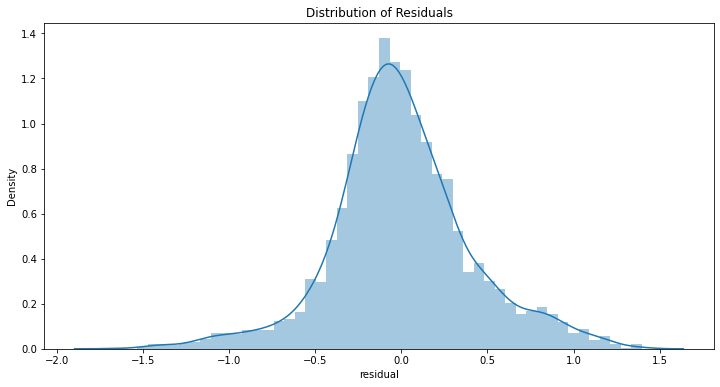

In [25]:
plt.subplots(figsize=(12, 6))
plt.title('Distribution of Residuals')
sns.distplot(residual_df['residual'])
plt.show()

### Homoskedasticity

This assumption states that there should be generally even variance across error terms. Plotting our residuals, we can see uniform variance does indeed exist:

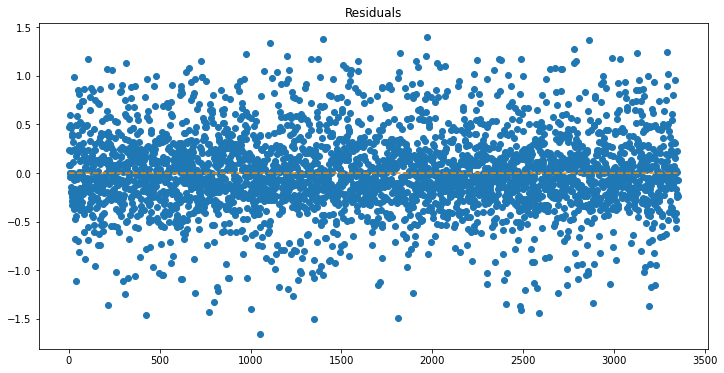

In [106]:
plt.subplots(figsize=(12, 6))
ax = plt.subplot(111)  # To remove spines
plt.scatter(x=residual_df.index, y=residual_df['residual'])
plt.plot(np.repeat(0, residual_df.index.max()), color='darkorange', linestyle='--')
plt.title('Residuals')
plt.show()  

### No autocorrelation of errors

A violation of this assumption would suggest the model is systematically mispredicting based on the characteristics of the predictors. `statsmodels` has a nice autocorrelation function (ACF) to plot residuals with and check.

Additionally, we can use the Durbin-Watson test to test for presence of significant autocorrelation at lag 1:
* If the value of the test statistic is close to 2.0, then there is no significant autocorrelation present
* If the value of the test statistic is between 0 and 2, then presence of positive autocorrelation is indicated
* If the value of the test statistic is between 2 and 4, then presence of negative autocorrelation is indicated

For more information on the Durbin-Watson statistic, please go here: https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic

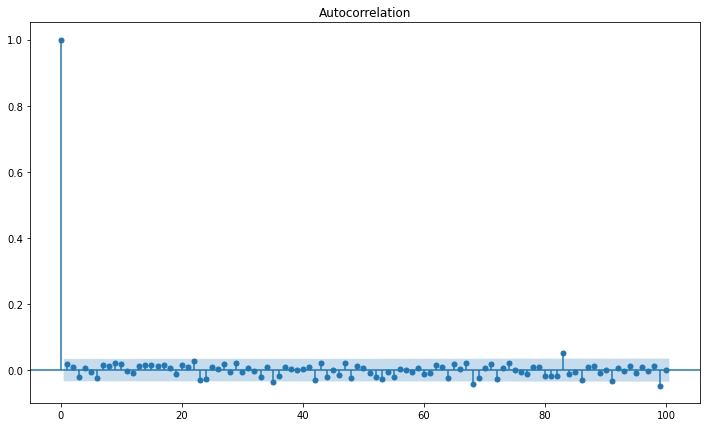

In [127]:
plt.close()
fig, axes = plt.subplots(figsize=(12, 7))
acf = smt.graphics.plot_acf(residual_df['residual'], lags=100 , alpha=0.05, ax=axes)

In [105]:
durbin_watson(residual_df['residual']])

1.9642045132175623

### Results on test set:

In [161]:
def evaluate_results(df, act_col, pred_col):
    print('R^2 score:', r2_score(df[act_col], df[pred_col]))
    print('MAE:', mean_absolute_error(df[act_col], df[pred_col]))
    print('MSE:', mean_squared_error(df[act_col], df[pred_col]))
    print('RMSE:', np.sqrt(mean_squared_error(df[act_col], df[pred_col])))

In [162]:
# log
evaluate_results(residual_df, 'act_log', 'pred_log')

R^2 score: 0.8476108347630871
MAE: 0.3015238091997568
MSE: 0.16703992970237766
RMSE: 0.4087051867818387


In [163]:
# dollars
evaluate_results(residual_df, 'act', 'pred')

R^2 score: 0.7747591077328055
MAE: 10190.682762640441
MSE: 494407171.68681973
RMSE: 22235.268644359116


---

Using multiple linear regression yielded decent results. Predictions were alright, but the model could be improved to be more accurate. Given the multicollinearity and the not-perfect linearity of residuals, I think that a tree-based model might be more appropriate here. Let's try a gradient boosted machine instead.

## GBM Regressor

Tree models work well for data with nonlinear, complex, or messy relationships that might not be obvious. Additionally, using an ensemble with boosting will help with overfitting. 

Let's say that we are CarMax, Carvana, etc. and use this model for automobile valuations. We want to assign the most appropriate price to each car we buy and sell in order to maximize our margins and our profits, while also maintaining competitive pricing and business with customers. That is, we want the model with the best performance on valuing our current inventory, and any new inventory that we might procure.

### Hyperparameter tuning

Let's conduct a grid search over the following hyperparameters in order to find the best combination:
* `learning_rate` - shrinks the contribution of each tree; trade-off with number of estimators
* `min_samples_split` - minimum number of samples required to split a node, as number of nodes or as a percentage
* `max_depth` - maximum depth (number of nodes) an individual tree can go
* `n_estimators` - the number of boosting stages to be performed

In [36]:
# define hyperparameters
parameters = {
    "learning_rate": [0.01, 0.05, 0.1],
    "min_samples_split": [2, 10, 100],
    "max_depth":[3, 5, 8],
    "n_estimators":[10, 100, 1000]
}

# create estimator
gbm = GradientBoostingRegressor(loss='ls', criterion='friedman_mse')

# conduct grid search with cross-validation
gs_cv = GridSearchCV(estimator=gbm, param_grid=parameters, refit=True, cv=5, n_jobs=-1, verbose=3)
gs_cv.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 45.0min finished


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 8],
                         'min_samples_split': [2, 10, 100],
                         'n_estimators': [10, 100, 1000]},
             verbose=3)

In [140]:
# save the object to disk
dump(gs_cv, 'car_price_gridsearch.pkl')

['car_price_gridsearch.pkl']

The optimal parameters from the grid search:
* Learning rate: 0.1
* Min samples split: 100
* Max tree depth: 8
* Number of estimators: 1000

In [151]:
optimal_params = gs_cv.best_estimator_.get_params()
pd.DataFrame.from_dict(optimal_params, orient='index', columns=['Parameter'])

,Parameter
alpha,0.9
ccp_alpha,0
criterion,friedman_mse
init,None
learning_rate,0.1
loss,ls
max_depth,8
max_features,None
max_leaf_nodes,None
min_impurity_decrease,0


### R^2 score

This model provides a huge lift over the GLM previously used. The R^2 scores for both the training set, and the held-out testing set are 99% and 98% each, respesctively.

In [171]:
gbm_train_preds = gs_cv.best_estimator_.predict(X_train)
print('Train R^2:', r2_score(y_train, gbm_train_preds))

gbm_test_preds = gs_cv.best_estimator_.predict(X_test)
print('Test R^2:', r2_score(y_test, gbm_test_preds))

Train R^2: 0.996161563206592
Test R^2: 0.9841009375546063


In [170]:
# calculate residuals
gbm_residual_df = pd.DataFrame({'act': y_test, 'pred': gbm_test_preds})
gbm_residual_df['residual'] = abs(y_test) - abs(gbm_test_preds)

# evaluate model results
evaluate_results(gbm_residual_df, 'act', 'pred')

R^2 score: 0.9841009375546063
MAE: 2754.7000768292733
MSE: 34898682.99213864
RMSE: 5907.510727213167


### Residuals

The residuals are much smaller, and are much more densely centered around 0:

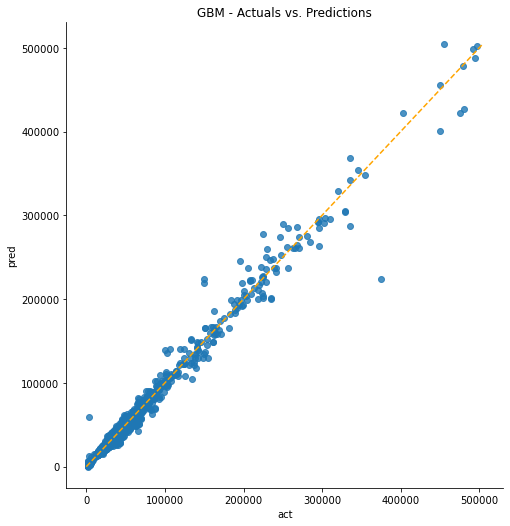

In [173]:
residual_plot(gbm_residual_df, 'act', 'pred', 'GBM - Actuals vs. Predictions')

C:\Users\siraj\miniconda3\envs\kaggle\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


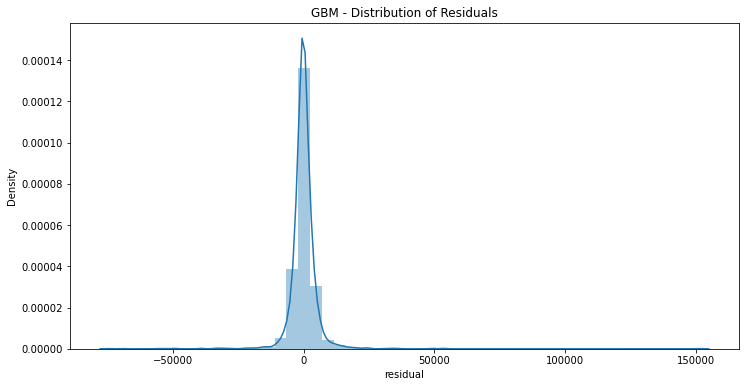

In [174]:
plt.subplots(figsize=(12, 6))
plt.title('GBM - Distribution of Residuals')
sns.distplot(gbm_residual_df['residual'])
plt.show()

### Feature importances:

Let's take a look at the top 10 most important features (based on impurity):

Horsepower, number of cylinders, fuel economy, and popularity look to be the best indicators in our car price prediction model.

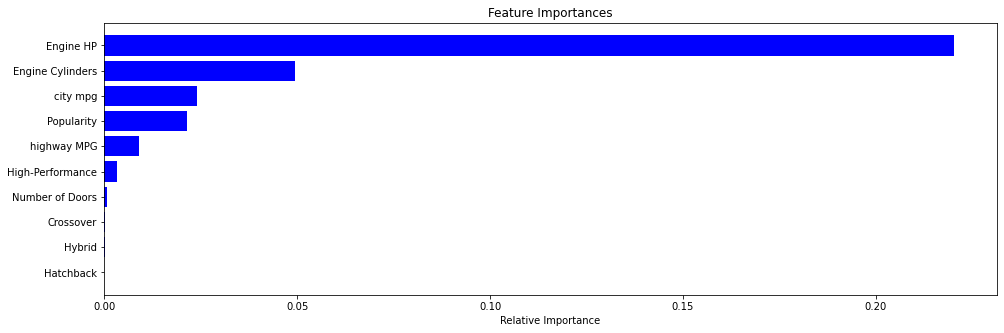

In [176]:
feature_importances = gs_cv.best_estimator_.feature_importances_
top_importances = feature_importances[:10]
indices = np.argsort(top_importances)

plt.close()
plt.figure(figsize=(16,5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), top_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [FEATURES[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

---
## Conclusion

The GBM significantly outperforms the linear model when predicting car price, given the existing data used here. Using a model like this, we can take it a step further to look at where the model underperforms:
* Which makes and models is the model under or overpredicting
  * e.g., if we set a reasonable threshold of 10% misprediction, which cars give the model the most trouble?
* What are the characteristics of the cars whose prices are being mispredicted?
  * e.g., does the model think that cars with V8s are overpriced?
* Are there other missing key features to take into consideration?
  * e.g., what do consumers generally look for when determining if the price of a car is appropriate for them?

For instance, if we find that 4-cylinder Chevrolet diesels from the mid 2000s are generally being over or undervalued, we can go out and get more data and recalibrate the model.


## Final note

Data is powerful. Very insightful relationships can be uncovered within data to inform business decisions and ultimately drive revenue, improve customer success, and improve user experience.

Thanks for reading, and happy learning.